# Лабораторная работа 1. Pandas, метод ближайших соседей и решающие деревья.

ФИО: Думбай Алексей Дмитриевич

Группа: 317

In [1]:
import numpy as np
import pandas as pd

## Часть 1: Pandas

#### Ответьте на вопросы о данных по авиарейсам в США за январь-апрель 2008 года.

Данные: http://stat-computing.org/dataexpo/2009/2008.csv.bz2
(обратите внимание, что распаковывать этот файл не обязательно — функция `pandas.read_csv` умеет читать из архивов автоматически)

Описание: http://stat-computing.org/dataexpo/2009/the-data.html

1. Какая из причин отмены рейса (`CancellationCode`) была самой частой? (расшифровки кодов можно найти в описании данных)
2. Найдите среднее, минимальное и максимальное расстояние, пройденное самолетом.
3. Не выглядит ли подозрительным минимальное пройденное расстояние? В какие дни и на каких рейсах оно было? Какое расстояние было пройдено этими же рейсами в другие дни?
4. Из какого аэропорта было произведено больше всего вылетов? В каком городе он находится?
5. Найдите для каждого аэропорта среднее время полета (`AirTime`) по всем вылетевшим из него рейсам. Какой аэропорт имеет наибольшее значение этого показателя?
6. Найдите аэропорт, у которого наибольшая доля задержанных (`DepDelay > 0`) рейсов. Исключите при этом из рассмотрения аэропорты, из которых было отправлено меньше 1000 рейсов (используйте функцию `filter` после `groupby`).

In [247]:
obj = pd.read_csv('2008.csv')

In [248]:
airports = pd.read_csv('airports.csv')

In [4]:
type_cancel = {'A' : 'carrier', 'B' : 'weather', 'C' : 'NAS', 'D' : 'security'}
tmp = obj['CancellationCode'].mode()
for i in tmp:
    print('1. Наиболее частая причина срыва рейса:', type_cancel[i])

1. Наиболее частая причина срыва рейса: weather


In [256]:
print('2. Расстояние пройденное самолетом:\nМаксимальное:', obj['Distance'].max())
print('Минимальное:', obj['Distance'].min())
print('Среднее:', obj['Distance'].mean())

2. Расстояние пройденное самолетом:
Максимальное: 4962
Минимальное: 11
Среднее: 726.3870294253928


Со всей ответственность можно утверждать, что да, расстояние кажется подозрительным.

In [263]:
flight_num = obj[obj.Distance == 11]

In [270]:
info_fl = flight_num[["Month", "DayofMonth", "DayOfWeek", "FlightNum"]]
    

In [272]:
print("Минимальное расстояние достигалось на следующих рейсах в следующие дни(2008 год):")
info_fl

Минимальное расстояние достигалось на следующих рейсах в следующие дни(2008 год):


,Month,DayofMonth,DayOfWeek,FlightNum
2547298,5,15,4,4988
4392215,8,10,7,5572


In [278]:
for i in flight_num.FlightNum:
    print("Рейс номер ", i, 'в среднем проходил', obj[obj.FlightNum == i].Distance.mean(), 'миль')

Рейс номер  4988 в среднем проходил 770.2088888888889 миль
Рейс номер  5572 в среднем проходил 384.75181598062954 миль


In [253]:
print('4. Наиболее частые вылеты из аэропортов:')
for i in obj['Origin'].mode():
    print(airports.groupby(['iata'])["airport"].first()[i],
          airports.groupby(['iata'])["city"].first()[i])

4. Наиболее частые вылеты из аэропортов:
William B Hartsfield-Atlanta Intl Atlanta


In [254]:
answ = obj.groupby(["Origin"])['AirTime'].mean()
print('5. Наибольшее значение средней длины полета из аэропорта имеет:',
      airports.groupby(['iata'])["airport"].first()[answ.idxmax()],
      airports.groupby(['iata'])["city"].first()[answ.idxmax()])
      

5. Наибольшее значение средней длины полета из аэропорта имеет: Luis Munoz Marin International San Juan


In [252]:
num_fl = obj[["Origin", "DepDelay"]]
airport_num = num_fl.groupby(["Origin"])
new_airp = airport_num.filter(lambda x: len(x) >= 1000)
dep_air_size = new_airp[new_airp.DepDelay > 0].groupby(["Origin"]).size()
all_size = new_airp.groupby("Origin").size()
new_series = dep_air_size / all_size 
print('6. Наибольшую долю задержанных самолетов имеет:',
      airports.groupby(['iata'])["airport"].first()[new_series.idxmax()],
      airports.groupby(['iata'])["city"].first()[new_series.idxmax()])

6. Наибольшую долю задержанных самолетов имеет: Dallas Love  Dallas


## Часть 2: метрические методы и категориальные признаки

Все дальнейшие эксперименты предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [3]:
data = pd.read_csv('amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
data.shape

(32769, 10)

In [5]:
# доля положительных примеров
data.ACTION.mean()

0.9421099209618847

In [6]:
# число значений у признаков
for col_name in data.columns:
    print (col_name, len(data[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре.

Проще всего будет определить метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba). Можно реализовать метод k ближайших соседей и самостоятально — в этом случае учитите, что он должен возвращать оценку вероятности, то есть отношение объектов первого класса среди соседей к числу соседей).

Постарайтесь уделить особое внимание эффективности кода — при реализации метрик "в лоб" вы можете столкнуться с очень большим временем выполнения.

#### Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Мера качества — AUC-ROC.

#### Какая функция расстояния оказалась лучшей?

In [8]:
from sklearn import neighbors
from sklearn import metrics
import sklearn

Приведение выборки к numpy для ускорения вычислений

In [37]:
X_tr = np.array(X_train)
y_tr = np.array(y_train)
x = np.array(X_test)
y = np.array(y_test)

Кодирование признаков от 0 до максимума по признаку:

In [10]:
max_len = 0
for col_name in data.columns:
    if(len(data[col_name].unique()) > max_len):
        max_len = len(data[col_name].unique())
X_trm = X_tr.copy()
x_m = x.copy()
for i in range(X_tr.shape[1]):
    A, B = np.unique(np.asarray(X_tr[:, i]), return_counts=True)
    tmp = {}
    for j in range(A.size):
        tmp[A[j]] = (j, B[j])
    for l in range(X_trm[:, i].size):
        X_trm[l, i] = tmp[X_trm[l,i]][0]
    for l in range(x_m[:, i].size):
        if (x_m[l, i] in tmp):
            x_m[l, i] = tmp[x_m[l,i]][0]
        else:
            x_m[l, i] = A.size

### Индекс совпадения 

In [231]:
def ind_eq(x,y):
    return np.sum((x != y))

In [232]:
cl = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='brute', leaf_size=30, p=2, metric=ind_eq, n_jobs=1)

In [233]:
cl.fit(X_tr, y_tr)


KNeighborsClassifier(algorithm='brute', leaf_size=30,
           metric=<function ind_eq at 0x000000F5F32B5C80>,
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [234]:
%time y_score = cl.predict_proba(x)

Wall time: 24min 20s


In [235]:
print("Для индикатора совпадения ROC-AUC равен",
      metrics.roc_auc_score(y, y_score[:,1])) 

Для индикатора совпадения ROC-AUC равен 0.829499015542


### Сглаженный индикатор совпадения

Предобработка для получения  значений p2(j)

In [10]:
prob = []
for i in range(X_tr.shape[1]):
    A, B = np.unique(np.asarray(X_tr[:, i]), return_counts=True)
    T = B.copy().astype(float)
    
    for l in range(T.size):
        T[l] = np.sum(B[B < B[l]] * (B[B < B[l]] - 1)) / np.sum(B) / (np.sum(B) - 1)
    T = np.append(T, np.zeros(max_len - T.size))
    prob += [T]
prob = np.array(prob)

In [11]:
def sec_r(x, y):
    return np.sum((x!=y) + (x==y) * np.diag(prob[:, (x).astype(int)]))
    

In [12]:
cl_2 = neighbors.KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='brute',
                                      leaf_size=30, metric= sec_r, n_jobs=1)

In [13]:
cl_2.fit(X_trm, y_tr)

KNeighborsClassifier(algorithm='brute', leaf_size=30,
           metric=<function sec_r at 0x000000756EB92840>,
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [14]:
%time y_score_2 = cl_2.predict_proba(x_m)


Wall time: 1h 11min 10s


In [15]:
print("Для сглаженного индикатора совпадения ROC-AUC равен",
      metrics.roc_auc_score(y, y_score_2[:,1]))

Для сглаженного индикатора совпадения ROC-AUC равен 0.833189474532


### Третья метрика

Преподсчет для получения произведения логарифмов

In [10]:
num = []
for i in range(X_tr.shape[1]):
    A, B = np.unique(np.asarray(X_tr[:, i]), return_counts=True)
    tmp_log= np.log(B + 1)
    t_2 = np.append(tmp_log, np.zeros(max_len - tmp_log.size))
    num += [t_2]
num = np.array(num)

In [11]:
def sec_r_2(x, y):
    return np.sum((x!=y) * np.diag(num[:, (x).astype(int)])* np.diag(num[:, (y).astype(int)]))
    

In [12]:
cl_3 = neighbors.KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='brute',
                                      leaf_size=30, metric= sec_r_2, n_jobs=1)

In [13]:
cl_3.fit(X_trm, y_tr)

KNeighborsClassifier(algorithm='brute', leaf_size=30,
           metric=<function sec_r_2 at 0x0000005892DF3A60>,
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [15]:
%time y_score_3 = cl_3.predict_proba(x_m)

Wall time: 2h 8min 51s


In [16]:
print("Для третей метрики ROC-AUC равен",
      metrics.roc_auc_score(y, y_score_3[:,1]))

Для третей метрики ROC-AUC равен 0.821046030503


Лучшей метрикой оказалась метрика "Сглаженный индикатор совпадения"

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось получить?

Для подбора можно использовать любые средства из sklearn.

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

#### Реализация без фолдинга.

In [11]:
suc_counts = []
suc_c_2 = []
for i in range(X_trm.shape[1]):
    A, B = np.unique(X_trm[:, i], return_counts=True)
    B = np.append(B, np.zeros(1))
    suc_counts += [B[X_trm[:,i]]]
    suc_c_2 += [B[x_m[:,i]]]
    C = np.zeros(A.shape[0] + 1)
    for j in range(X_trm[:, i].shape[0]):
        if y_tr[j] == 1:
            C[X_trm[j,i]] += 1
    suc_counts += [C[X_trm[:,i]]]
    suc_c_2 += [C[x_m[:,i]]]
    suc_counts += [(C[X_trm[:,i]] + 1) / (B[X_trm[:,i]] + 2)]
    suc_c_2 += [(C[x_m[:,i]] + 1) / (B[x_m[:,i]] + 2)]
x_c = np.array(suc_c_2).T
X_trc = np.array(suc_counts).T

In [12]:
cl_4 = neighbors.KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='kd_tree',
                                      leaf_size=30, metric= 'euclidean', n_jobs=1)

In [13]:
cl_4.fit(X_trc, y_tr)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [20]:
max_k = 0
max_value = 0
for i in range(20):
    cl_4 = neighbors.KNeighborsClassifier(n_neighbors=(i + 1), weights='uniform', algorithm='kd_tree',
                                      leaf_size=30, metric= 'euclidean', n_jobs=1)
    cl_4.fit(X_trc, y_tr)
    y_score_4 = cl_4.predict_proba(x_c)
    tmp = metrics.roc_auc_score(y, y_score_4[:,1])
    if(max_value < tmp):
        max_value = tmp
        max_k = i

In [22]:
print('Наилучшее значение без фолдинга достигается при количестве соседей:', max_k, 'со значением AUC-ROC равным', max_value)

Наилучшее значение без фолдинга достигается при количестве соседей: 13 со значением AUC-ROC равным 0.796091066126


##### Реализация с фолдингом



Подсчет счетчиков на тестовой выборке:

In [14]:
fold_cnt = []
for i in range(X_trm.shape[1]):
    A, B = np.unique(X_trm[:, i], return_counts=True)
    B = np.append(B, np.zeros(1))
    fold_cnt += [B[x_m[:,i]]]
    C = np.zeros(A.shape[0] + 1)
    for j in range(X_trm[:, i].shape[0]):
        if y_tr[j] == 1:
            C[X_trm[j,i]] += 1
    fold_cnt += [C[x_m[:,i]]]
    fold_cnt += [(C[x_m[:,i]] + 1) / (B[x_m[:,i]] + 2)]
x_fc = np.array(fold_cnt).T

Считаем счетчики на train

In [15]:
n_folds = 3
suc_fc = []

for i in range(X_trm.shape[1]):
    A, B = np.unique(X_trm[:, i], return_counts=True)
    cnt_v = np.zeros(X_trm.shape[0])
    scc_v = cnt_v.copy()
    diff_v = cnt_v.copy()
    for j in range(n_folds):
        pos1 = (X_trm.shape[0] * j)// n_folds
        pos2 = (X_trm.shape[0] * (j + 1))// n_folds
        cnt_tmp = np.zeros(B.size + 1)
        scc_tmp = np.zeros(B.size + 1)
        for k in range(pos1):
            cnt_tmp[X_trm[k, i]] += 1
            if y_tr[k] == 1:
                scc_tmp[X_trm[k, i]] += 1
        for k in range(pos2, X_trm.shape[0]):
            cnt_tmp[X_trm[k, i]] += 1
            if y_tr[k] == 1:
                scc_tmp[X_trm[k, i]] += 1
        for k in range(pos1, pos2):
            cnt_v[k] = cnt_tmp[X_trm[k, i]]
            scc_v[k] = scc_tmp[X_trm[k, i]]
            diff_v[k] = (scc_tmp[X_trm[k,i]] + 1)/ (cnt_tmp[X_trm[k, i]] + 2)
    cnt_v = cnt_v * n_folds / (n_folds - 1) 
    scc_v = scc_v * n_folds / (n_folds - 1)
    suc_fc += [cnt_v, scc_v, diff_v]

X_trfc = np.array(suc_fc).T

In [82]:
cl_5 = neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='kd_tree',
                                      leaf_size=30, metric= 'euclidean', n_jobs=1)
cl_5.fit(X_trfc, y_tr)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [85]:
max_k = 0
max_value = 0
for i in range(50):
    cl_5 = neighbors.KNeighborsClassifier(n_neighbors=(i + 1), weights='uniform', algorithm='kd_tree',
                                      leaf_size=30, metric= 'euclidean', n_jobs=1)
    cl_5.fit(X_trfc, y_tr)
    y_score_5 = cl_5.predict_proba(x_fc)
    tmp = metrics.roc_auc_score(y, y_score_5[:,1])
    if(max_value < tmp):
        max_value = tmp
        max_k = i

In [86]:
print('Наилучшее значение без фолдинга достигается при количестве соседей:', (max_k + 1), 'со значением AUC-ROC равным', max_value)

Наилучшее значение без фолдинга достигается при количестве соседей: 19 со значением AUC-ROC равным 0.77653507495


#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

Добавление парных признаков

In [16]:
X_str = X_trm.astype(str)
x_str = x_m.astype(str)

In [17]:
Z = []
D = []
for i in range(X_str.shape[1]):
    Z += [X_str[:,i]]
    for j in range(i + 1, X_str.shape[1]):
        C = X_str[:,i].copy()
        for k in range(C.shape[0]):
            C[k] = C[k] + '&' + X_str[k, j]
        Z += [C]
        
for i in range(x_str.shape[1]):
    D += [x_str[:,i]]
    for j in range(i + 1, x_str.shape[1]):
        C = x_str[:,i].copy()
        for k in range(C.shape[0]):
            C[k] = C[k] + '&' + x_str[k, j]
        D += [C]

In [18]:
X_new = np.array(Z).T
x_new = np.array(D).T

In [19]:
data_new = np.array(list(np.array(Z).T) + list((np.array(D).T)))

#### Без фолдинга

In [20]:
max_len = 0
for i in range(data_new.shape[1]):
    if(np.unique(data_new[:,i]).shape[0] > max_len):
        max_len = np.unique(data_new[:,i]).shape[0]
X_new_m = X_new.copy()
x_new_m = x_new.copy()
for i in range(X_new.shape[1]):
    A, B = np.unique(np.asarray(X_new[:, i]), return_counts=True)
    tmp = {}
    for j in range(A.size):
        tmp[A[j]] = (j, B[j])
    for l in range(X_new_m[:, i].size):
        X_new_m[l, i] = tmp[X_new_m[l,i]][0]
    for l in range(x_new_m[:, i].size):
        if (x_new_m[l, i] in tmp):
            x_new_m[l, i] = tmp[x_new_m[l,i]][0]
        else:
            x_new_m[l, i] = A.size
X_new_m = X_new_m.astype(int)
x_new_m = x_new_m.astype(int)

In [21]:
suc_counts = []
suc_c_2 = []
for i in range(X_new_m.shape[1]):
    A, B = np.unique(X_new_m[:, i], return_counts=True)
    B = np.append(B, np.zeros(1))
    suc_counts += [B[X_new_m[:,i]]]
    suc_c_2 += [B[x_new_m[:,i]]]
    C = np.zeros(A.shape[0] + 1)
    for j in range(X_new_m[:, i].shape[0]):
        if y_tr[j] == 1:
            C[X_new_m[j,i]] += 1
    suc_counts += [C[X_new_m[:,i]]]
    suc_c_2 += [C[x_new_m[:,i]]]
    suc_counts += [(C[X_new_m[:,i]] + 1) / (B[X_new_m[:,i]] + 2)]
    suc_c_2 += [(C[x_new_m[:,i]] + 1) / (B[x_new_m[:,i]] + 2)]
x_nc = np.array(suc_c_2).T
X_ntrc = np.array(suc_counts).T

In [134]:
max_k = 0
max_value = 0
for i in range(20):
    cl_p = neighbors.KNeighborsClassifier(n_neighbors=(i + 1), weights='uniform', algorithm='kd_tree',
                                      leaf_size=30, metric= 'euclidean', n_jobs=1)
    cl_p.fit(X_ntrc, y_tr)
    y_p = cl_p.predict_proba(x_nc)
    tmp = metrics.roc_auc_score(y, y_p[:,1])
    if(max_value < tmp):
        max_value = tmp
        max_k = i

In [136]:
print('Наилучшее значение без фолдинга достигается при количестве соседей:',
      (max_k + 1), 
      'со значением AUC-ROC равным', 
      max_value)

Наилучшее значение без фолдинга достигается при количестве соседей: 8 со значением AUC-ROC равным 0.801859076241


#### С фолдиногом

In [22]:
fold_cnt = []
for i in range(X_new_m.shape[1]):
    A, B = np.unique(X_new_m[:, i], return_counts=True)
    B = np.append(B, np.zeros(1))
    fold_cnt += [B[x_new_m[:,i]]]
    C = np.zeros(A.shape[0] + 1)
    for j in range(X_new_m[:, i].shape[0]):
        if y_tr[j] == 1:
            C[X_new_m[j,i]] += 1
    fold_cnt += [C[x_new_m[:,i]]]
    fold_cnt += [(C[x_new_m[:,i]] + 1) / (B[x_new_m[:,i]] + 2)]
x_2 = np.array(fold_cnt).T

In [23]:
n_folds = 3
suc_fc = []

for i in range(X_new_m.shape[1]):
    A, B = np.unique(X_new_m[:, i], return_counts=True)
    cnt_v = np.zeros(X_new_m.shape[0])
    scc_v = cnt_v.copy()
    diff_v = cnt_v.copy()
    for j in range(n_folds):
        pos1 = (X_new_m.shape[0] * j)// n_folds
        pos2 = (X_new_m.shape[0] * (j + 1))// n_folds
        cnt_tmp = np.zeros(B.size + 1)
        scc_tmp = np.zeros(B.size + 1)
        for k in range(pos1):
            cnt_tmp[X_new_m[k, i]] += 1
            if y_tr[k] == 1:
                scc_tmp[X_new_m[k, i]] += 1
        for k in range(pos2, X_new_m.shape[0]):
            cnt_tmp[X_new_m[k, i]] += 1
            if y_tr[k] == 1:
                scc_tmp[X_new_m[k, i]] += 1
        for k in range(pos1, pos2):
            cnt_v[k] = cnt_tmp[X_new_m[k, i]]
            scc_v[k] = scc_tmp[X_new_m[k, i]]
            diff_v[k] = (scc_tmp[X_new_m[k,i]] + 1)/ (cnt_tmp[X_new_m[k, i]] + 2)
    cnt_v = cnt_v * n_folds / (n_folds - 1) 
    scc_v = scc_v * n_folds / (n_folds - 1)
    suc_fc += [cnt_v, scc_v, diff_v]

X_2 = np.array(suc_fc).T

In [139]:
max_k = 0
max_value = 0
for i in range(20):
    cl_p2 = neighbors.KNeighborsClassifier(n_neighbors=(i + 1), weights='uniform', algorithm='kd_tree',
                                      leaf_size=30, metric= 'euclidean', n_jobs=1)
    cl_p2.fit(X_2, y_tr)
    y_p2 = cl_p2.predict_proba(x_2)
    tmp = metrics.roc_auc_score(y, y_p2[:,1])
    if(max_value < tmp):
        max_value = tmp
        max_k = i

In [140]:
print('Наилучшее значение c фолдингом достигается при количестве соседей:',
      (max_k + 1), 
      'со значением AUC-ROC равным', 
      max_value)

Наилучшее значение c фолдингом достигается при количестве соседей: 18 со значением AUC-ROC равным 0.790223316304


## Часть 3: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [142]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
X_tree = X_ntrc
x_tree = x_nc

In [230]:
max_answ = 0
d = 0
l = 0
dep = [1, 10, 20, 30, 50, 100, 1000]
leaf = [1, 10, 20, 30, 50, 100, 1000]
for i in dep:
    for j in leaf:
        cl_tree = DecisionTreeClassifier(max_depth = i, min_samples_leaf=j)
        cl_tree.fit(X_tree, y_tr)
        tmp = cl_tree.predict_proba(x_tree)
        answ = metrics.roc_auc_score(y, tmp[:,1])
        if(answ > max_answ):
            max_answ = answ
            d = i
            l = j

In [231]:
print('Итоговое качество на тестовой выборке:\nAUC-ROC:', max_answ, '\nmax_depth =', d, '\nmin_samples_leaf =',l)

Итоговое качество на тестовой выборке:
AUC-ROC: 0.66001250071 
max_depth = 1000 
min_samples_leaf = 10


#### 2. Настройте случайный лес, подобрав такое число деревьев `n_estimators`, при котором ошибка выходит на асимптоту. Какое качество на тестовой выборке он дает?

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [212]:
max_answ = 0
d = 0
l = 0
e = 0
dep = [1, 10, 20, 30, 50, 100, 500, 1000]
leaf = [1, 10, 20, 30, 50, 100, 500, 1000]
est = [5, 10, 30, 50]
for i in dep:
    print (i)
    for j in leaf:
        for k in  est:
            cl_forest = RandomForestClassifier(n_estimators=k, max_depth = i, min_samples_leaf=j)
            cl_forest.fit(X_tree, y_tr)
            fg = cl_forest.predict_proba(x_tree)
            answ = metrics.roc_auc_score(y, fg[:,1])
            if(answ > max_answ):
                max_answ = answl
                d = i
                l = j
                e = k

1
10
20
30
50
100
500
1000


In [220]:
print('AUC-ROC:', max_answ, 'max_depth =', d, 'min_samples_leaf =', l, 'n_estimators = ', e)

AUC-ROC: 0.826043259357 max_depth = 20 min_samples_leaf = 1000 n_estimators =  30


На лучшем варианте поиск другого числа n_estimators

In [53]:
x = [30,  50, 75, 100, 150, 200, 250]
yy = []

In [54]:
d = 20
l = 1000
max_answ = 0 
k = 0;
for i in x:
    cl_forest = RandomForestClassifier(n_estimators=i, max_depth=d, min_samples_leaf=l)
    cl_forest.fit(X_tree, y_tr)
    fg = cl_forest.predict_proba(x_tree)
    yy+=[metrics.roc_auc_score(y, fg[:,1])]
    if(metrics.roc_auc_score(y, fg[:,1]) > max_answ):
        max_answ = metrics.roc_auc_score(y, fg[:,1])
        k = i

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

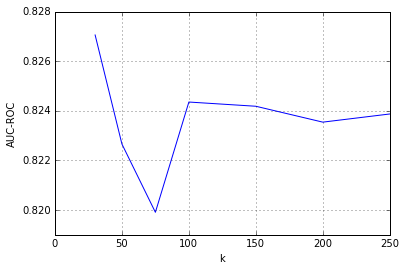

In [56]:
plt.plot(x, yy)
plt.xlabel('k')
plt.ylabel('AUC-ROC')
plt.grid()
plt.show()

In [57]:
print('Итоговое качество на тестовой выборке:\nAUC-ROC:', max_answ, '\nmax_depth =', d, '\nmin_samples_leaf =',
      l, '\nn_estimators = ', k)

Итоговое качество на тестовой выборке:
AUC-ROC: 0.82705736956 
max_depth = 20 
min_samples_leaf = 1000 
n_estimators =  30


Здесь и далее auc уходит на асимптоту, если учитывать то, какая мера шкалы AUC-ROC. 

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [232]:
X_f = X_2
x_f = x_2

In [234]:
max_answ = 0
d = 0
l = 0
e = 0
dep = [1, 10, 20, 30, 50, 100, 500, 1000]
leaf = [1, 10, 20, 30, 50, 100, 500, 1000]
est = [5, 10, 30, 50]
for i in dep:
    print (i)
    for j in leaf:
        for k in  est:
            cl_forest = RandomForestClassifier(n_estimators=k, max_depth = i, min_samples_leaf=j)
            cl_forest.fit(X_f, y_tr)
            fg = cl_forest.predict_proba(x_f)
            answ = metrics.roc_auc_score(y, fg[:,1])
            if(answ > max_answ):
                max_answ = answ
                d = i
                l = j
                e = k

1
10
20
30
50
100
500
1000


In [235]:
print('AUC-ROC:', max_answ, 'max_depth =', d, 'min_samples_leaf =', l, 'n_estimators = ', e)

AUC-ROC: 0.866261184325 max_depth = 50 min_samples_leaf = 20 n_estimators =  30


In [236]:
for i in [30, 50, 100, 200, 250, 300]:
    cl_forest = RandomForestClassifier(n_estimators=i, max_depth=d, min_samples_leaf=l)
    cl_forest.fit(X_tree, y_tr)
    fg = cl_forest.predict_proba(x_tree)
    answ = metrics.roc_auc_score(y, fg[:,1])
    if(answ > max_answ):
        max_answ = answ
        e = k

In [246]:
print('Итоговое качество на тестовой выборке:\nAUC-ROC:', max_answ, '\nmax_depth =', d, '\nmin_samples_leaf =',
      l, '\nn_estimators = ', e)

Итоговое качество на тестовой выборке:
AUC-ROC: 0.866261184325 
max_depth = 50 
min_samples_leaf = 20 
n_estimators =  30


Я думаю, что на качестве модели сказалось то, что переобучения не происходит. Чего мы и добились с помощью фолдинга. Причем благодаря большому кол-ву деревьев это оказывает реальный эффект.

Здесь вы можете поделиться своими мыслями о задании.

Задание интересное, как для человека, который впервые столкнулся с анализом данных.


А здесь вставьте смешную картинку.

![Смешная(?) картинка](2.jpg)

А здесь посоветуйте преподавателям хороший фильм или сериал.

Из старых - Книжный магазин Блэка. 
Из новых - Проповедник.